## Tectonics and Landscape Evolution Class part 1



#### We are going to use our field work measurements to create our model from the Teton Fault

In [64]:
#Importing required functions 

import pandas as pd
from landlab import RasterModelGrid, imshow_grid
from landlab.components import StreamPowerEroder, LinearDiffuser, FlowAccumulator,NormalFault
import numpy as np
import matplotlib.pyplot as plt
from FieldWork_class import FieldWork

The average strike is 10.0
The average dip is 58.904761904761905


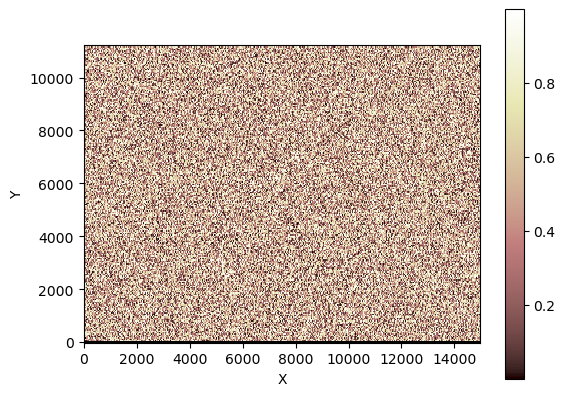

In [65]:
#Import you field work data
data = pd.read_csv('/Users/poliveira/Projects_PhD/tect_land_project/field_work_teton_park.csv')
data

#Calculate parameters for your model
fw = FieldWork(data)
result = fw.calculate_dip_strike()

#Set the size of your area
x_size = 15000 # in meters
y_size  = 11250 # in meters
dx = 30 #cell resolution in x
dy = 50 #cell resolution in y

#rows,cols = fw.calculate_grid_size(x_size,y_size,dx,dy) 

#create basin_mg
basin_mg = RasterModelGrid((rows,cols),xy_spacing=(30,50)) #rows = y, cols = x

# Add elevation field
np.random.seed(35)
z = basin_mg.add_zeros('topographic__elevation', at='node')
z += np.random.rand(z.size)

# Set boundary conditions to match Teton

basin_mg.set_closed_boundaries_at_grid_edges(False,True,False,True) #top,left,bottom,right
imshow_grid(basin_mg, 'topographic__elevation')
# plt.show()




In [66]:
## Initialise the landscape and parameters

# Dictionary for parameter values
params  = {'stream_power': {'K_sp': 5E-6, 
                        'n_sp': 1, 
                        'm_sp': 0.45}, 
                        'diffuser': {'D_diff': 0.001}}

K_sp = params['stream_power']['K_sp']
m_sp = params['stream_power']['m_sp']
n_sp = params['stream_power']['n_sp']

## Forward model evolution

n_steps = 100001
dt = 1000  # timestep in years

U = np.ones(basin_mg.number_of_nodes)
uplift_rate = 0.000500 #in meters/years
U = U*uplift_rate

fa = FlowAccumulator(basin_mg, flow_director='D8')
ld = LinearDiffuser(basin_mg, linear_diffusivity=params['diffuser']['D_diff'])
sp = StreamPowerEroder(basin_mg, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp)

uplift_per_steps = dt * U

#### For class purpose we are gonna load the steady state model from a txt-file

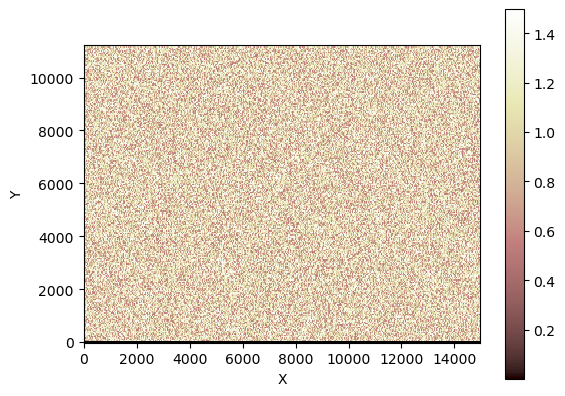

0


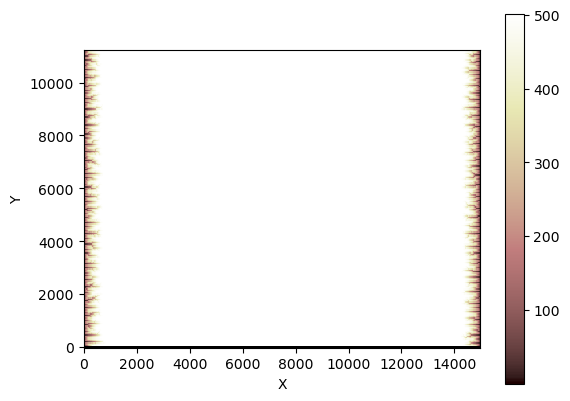

1000


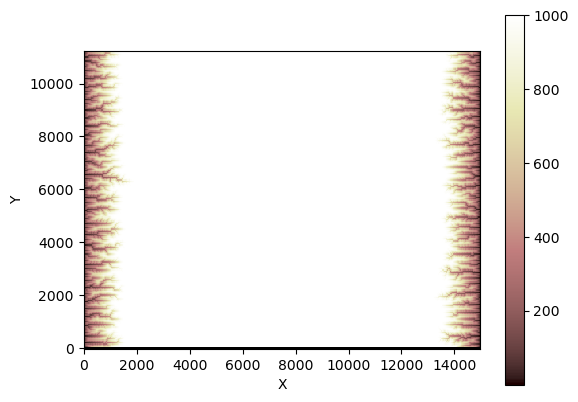

2000


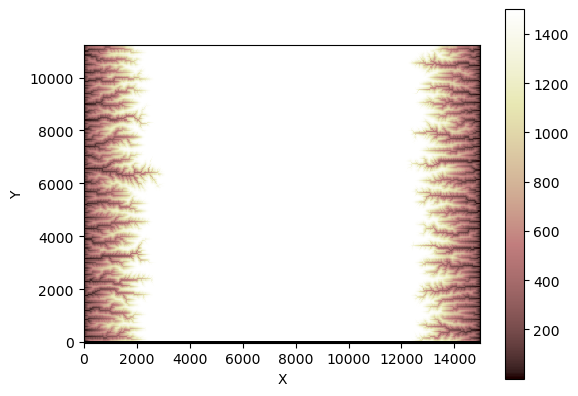

3000


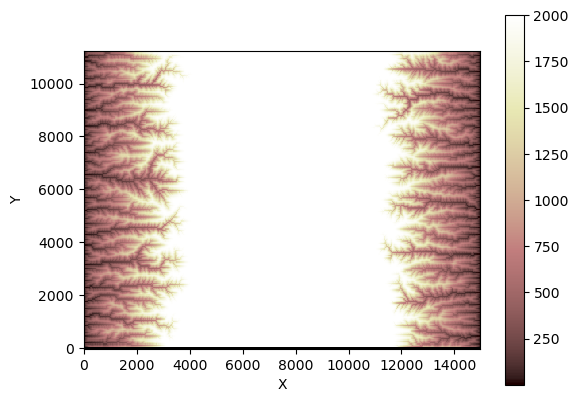

4000


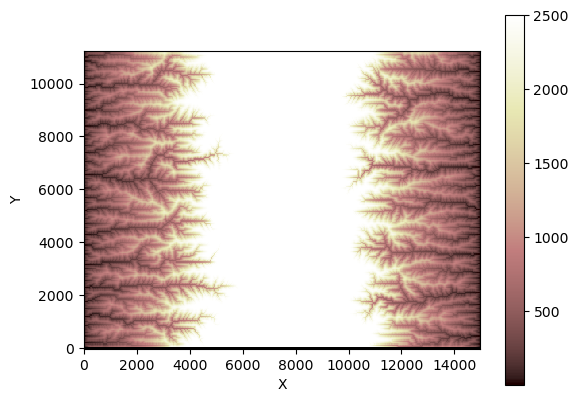

5000


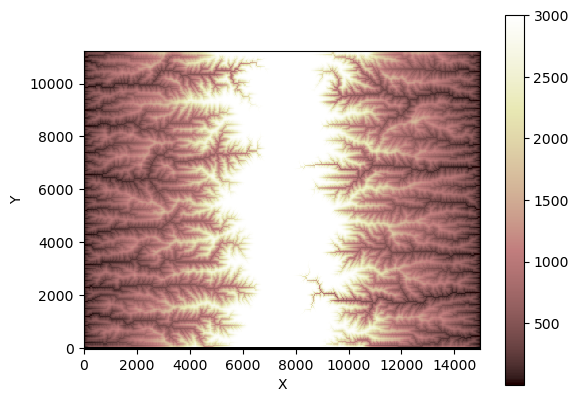

6000


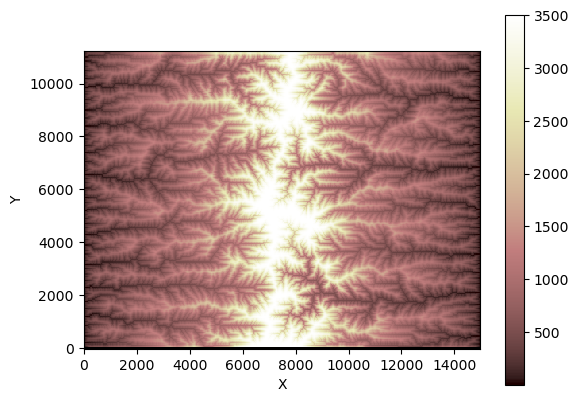

7000


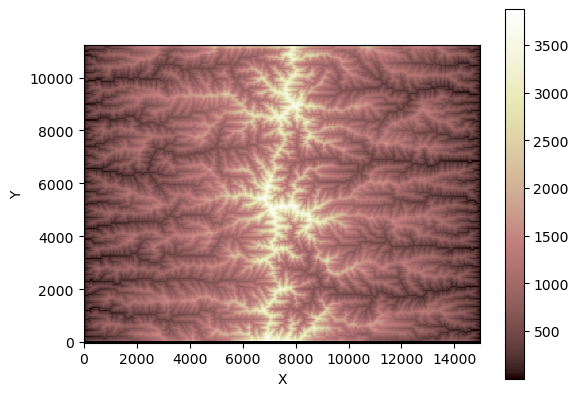

8000


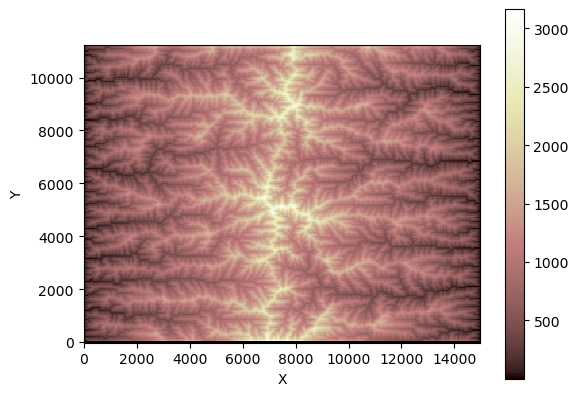

9000


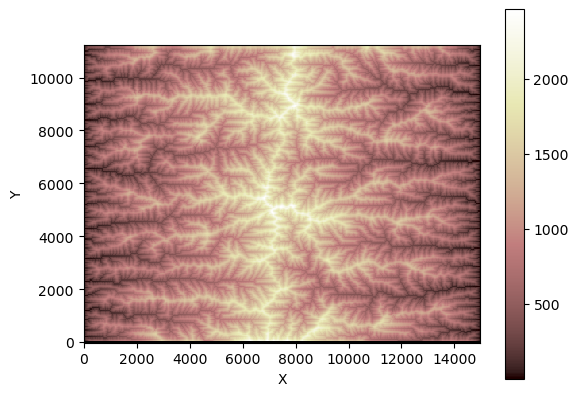

10000


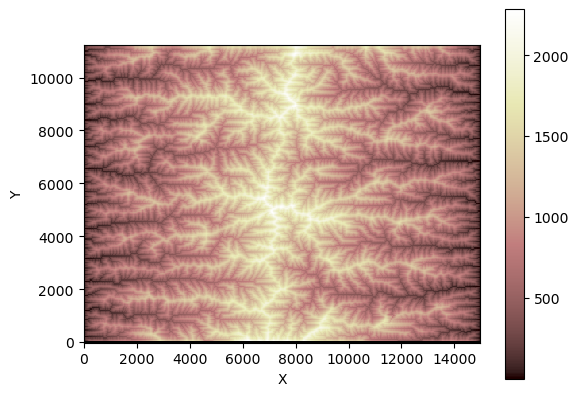

11000


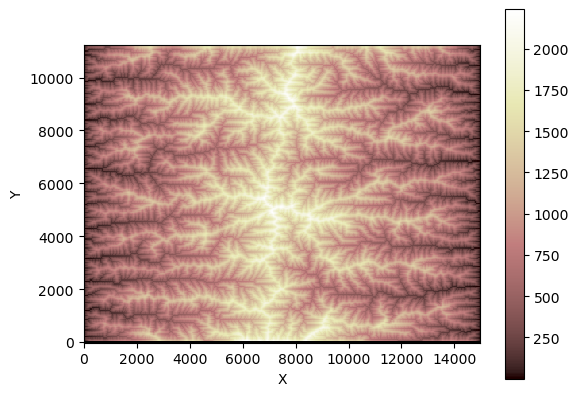

12000


KeyboardInterrupt: 

In [67]:
for i in range(n_steps):

    basin_mg.at_node['topographic__elevation'][basin_mg.core_nodes] += uplift_per_steps[basin_mg.core_nodes]
    fa.run_one_step()
    sp.run_one_step(dt=dt)
    ld.run_one_step(dt)

    if i%1000 == 0:
        imshow_grid(basin_mg, 'topographic__elevation')
        plt.show()
        print(i)

In [68]:
## save the model 

np.savetxt("model_teton_steady_state",basin_mg.at_node['topographic__elevation'])


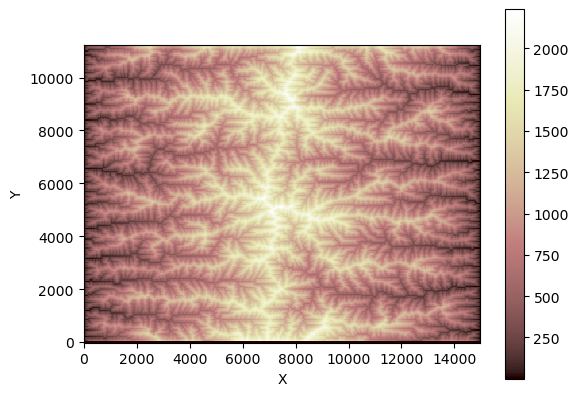

In [80]:
##load the model 
basin_fault_mg = RasterModelGrid((rows,cols),xy_spacing=(30,50))
basin_fault_mg.at_node['topographic__elevation'] = np.loadtxt("/Users/poliveira/Projects_PhD/tect_land_project/model_teton_steady_state")

z_f = basin_fault_mg.at_node['topographic__elevation']

basin_fault_mg.set_closed_boundaries_at_grid_edges(True,False,True,False)

imshow_grid(basin_fault_mg, 'topographic__elevation')


### Setting up our fault from our steady-state model



In [81]:
## Setting parameters for normal fault event

params_fault = {
             "faulted_surface": "topographic__elevation",
             "fault_dip_angle": 45,
             "fault_throw_rate_through_time": {
                 "time": [100000],
                 "rate": [0.0001],
             },
             "fault_trace": {"y1": 0, "x1": 4000, "y2": 11000, "x2": 8000},
             "include_boundaries": True,
         }

nf = NormalFault(basin_fault_mg, **params_fault)

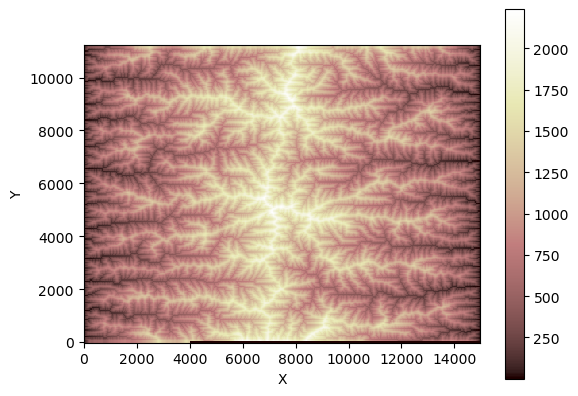

0


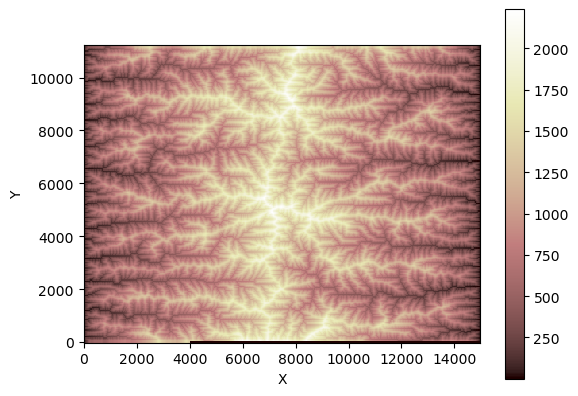

100


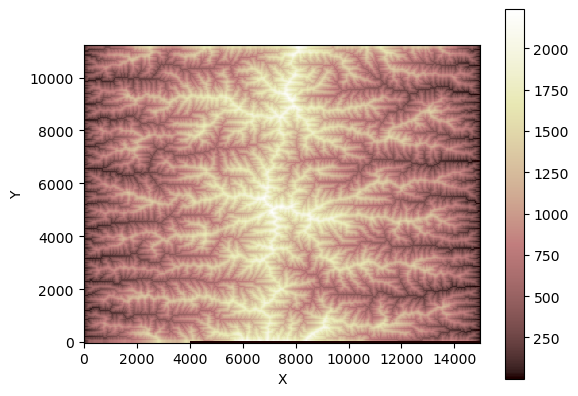

200


In [82]:
for i in range(n_steps):
    fa.run_one_step()
    sp.run_one_step(dt=dt)
    ld.run_one_step(dt)
    nf.run_one_step(dt)

    if i%100 == 0:
        imshow_grid(basin_fault_mg, 'topographic__elevation')
        plt.show()
        print(i)

In [ ]:
##topographic analyses here

from landlab.components import (
    ChannelProfiler,
    ChiFinder,
    SteepnessFinder,
)

theta = m_sp / n_sp
# initialize the component that will calculate channel steepness
sf = SteepnessFinder(mg1, reference_concavity=theta, min_drainage_area=1000.0)
# initialize the component that will calculate the chi index
cf = ChiFinder(mg1,
               min_drainage_area=1000.0,
               reference_concavity=theta,
               use_true_dx=True)
